In [1]:

%pprint
%matplotlib inline
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import (nu, fu, np, re, Series, DataFrame, display)
from nltk import ngrams, FreqDist, word_tokenize
from numpy import arange
import matplotlib.pyplot as plt
import operator
import os
import random
import string
from wordcloud import WordCloud

In [12]:

# load data frames
data_frames_dict = nu.load_data_frames(frvrs_logs_df='', file_stats_df='')
frvrs_logs_df = data_frames_dict['frvrs_logs_df']
file_stats_df = data_frames_dict['file_stats_df']

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/file_stats_df.pkl.



# Questionable Voice Commands

In [7]:

# Get the scene stats
data_frames_dict = nu.load_data_frames(scene_stats_df='')
scene_stats_df = data_frames_dict['scene_stats_df']
# registry_scene_mask_series = scene_stats_df.session_uuid.isin(registry_set) & (scene_stats_df.scene_type == 'Triage')

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/scene_stats_df.pkl.



## Voice command issued and (not) all patients logged command

In [9]:

questionable_walk_commands = [
    'Go', 'Go to start', 'I need you to go outside', "OK OK i'm gonna go ahead and have your head up the stairs OK",
    "OK buddy I want you to go ahead and go over to the collection point that we have there'll be more people over there to help", 'OK go away',
    'OK go right there', 'OK so go to this one first', 'OK then I need you to go outside', 'You go here', 'alright anyone can stand up go to stairs',
    'alright do i need to go is do i need to go like back way over there', 'alright go ahead and have a seat by the stairs for me',
    'alright go stand over by the exit if you can hear me wave your hand wave your hand', 'alright go upstairs and see the ambulance drivers',
    'alright so go over here', 'anyone who can stand and get up please go over to a bench',
    "can I have you just go over to our collection point and somebody will be there actually you can just go on to the ER or go home or do whatever" +
    " you need to do right now but I'm gonna have you leave this area please OK for your safety", "don't give you a delayed tag you go over here", 'go',
    'go away', 'go back', 'go back to heaven', 'go here', 'go home', 'go if you', 'go over here', 'go over to a wall', 'go that way', 'go this way', 'go to',
    'go to start', "good post so why don't you go sit down OK", 'hearing anything if you can hear my voice please go over to the stairwell',
    'hey can you move go upstairs', 'hey go away', 'hey go back to the sky over here',
    "him sit down on the step so that way he's not moving around sir can you go sit down on the", 'i know there go',
    "i'm gonna go ahead and have you head up the stairs OK", 'just go here', 'just go red here OK', 'just stand up and go away now OK', "let's go over here",
    "man that's just I'm gonna make her immediate sorry bro I know you you probably said I could do something else to her Sir why don't you go sit over" +
    " there on the stairs", 'moonlight now I I want you to go over to that corner', 'nothing go away',
    'oh my gosh OK alright if you guys can hear me go ahead and make your way up the stairs', 'sir you wanna move it all these guys go',
    "so first thing you do is to do i like talk it through like you know the scene safe kind of things alright if you can hear me and you're safe i want" +
    " you to go to a safe area no one's getting up yep get up there we go", 'so go here', 'sweep sweep sweep sweep sweep no what are you you you need to go',
    'thank you just go ahead and sit along the steps', 'thank you thank you to my right there you go over by the stairwell please',
    "that's the only place you could go so", 'we can move can you leave and go up the stairs', 'you can go outside', 'you go home', 'you gotta go through',
    'you guys go up the stairs', "you guys hurt go upstairs if you're hurt",
    "you too you look like you're doing pretty good I'm gonna have you go over to our collection point will there be more people there to help you OK"
]

In [10]:

# Group each scene that has voice command issued
mask_series = ~frvrs_logs_df.voice_command_message.isin(['walk to the safe area']) & ~frvrs_logs_df.voice_command_message.isnull()
scene_gb = frvrs_logs_df[mask_series].sort_values(['action_tick']).groupby(fu.scene_groupby_columns)

# Loop through each unique file/scene combination and see if all patients logged a walkcommand
rows_list = []
for (session_uuid, scene_id), idx_df in scene_gb:
    
    # Check if it's a triage scene
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (scene_stats_df[cn] == eval(cn))
    mask_series &= (scene_stats_df.scene_type == 'Triage')
    if mask_series.any():
        
        # Get entire scene history
        mask_series = True
        for cn in fu.scene_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
        scene_df = frvrs_logs_df[mask_series]
        
        # Get the patients set
        mask_series = ~scene_df.patient_id.isnull()
        patients_set = set(scene_df[mask_series].patient_id.unique())
        
        # Get the actions list
        actions_list = []
        
        # Create a boolean mask to filter start/stop and the walk commands received by patients
        voice_actions_list = ['SESSION_END', 'SESSION_START', 'S_A_L_T_WALK_IF_CAN']
        actions_mask_series = scene_df.action_type.isin(voice_actions_list)
        
        # Include VOICE CAPTURE actions with questionable walk commands
        questionable_mask_series = ((scene_df.action_type == 'VOICE_CAPTURE') & scene_df.voice_capture_message.isin(questionable_walk_commands))
        actions_mask_series |= questionable_mask_series
        
        # Include voice commands with the message "walk to the safe area"
        walk_mask_series = (scene_df.action_type == 'VOICE_COMMAND') & scene_df.voice_command_message.isin(['walk to the safe area'])
        actions_mask_series |= walk_mask_series
        
        for row_index, row_series in scene_df[actions_mask_series].iterrows():
            action_type = row_series.action_type
            if action_type == 'S_A_L_T_WALK_IF_CAN': actions_list.append(row_series.s_a_l_t_walk_if_can_sort_command_text)
            elif action_type == 'VOICE_COMMAND': actions_list.append(row_series.voice_command_command_description)
            elif (action_type == 'VOICE_CAPTURE'): actions_list.append(row_series.voice_capture_message)
            elif action_type in ['SESSION_END', 'SESSION_START']: actions_list.append(action_type)
        
        # Count any pressing of the moderator button
        moderator_count = actions_list.count('walk to the safe area')
        
        # Get rid of any consecutive elements
        for element in ['walkIfCan', 'walk to the safe area']:
            actions_list = nu.replace_consecutive_elements(actions_list, element)
        
        # Get the walk-if-cans set
        mask_series = (scene_df.s_a_l_t_walk_if_can_sort_command_text == 'walkIfCan')
        mask_series &= ~scene_df.patient_id.isnull()
        walk_if_cans_set = set(scene_df[mask_series].patient_id.unique())
        
        # Create a row in the data frame
        row_dict = {}
        for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
        row_dict['patient_count'] = len(patients_set)
        row_dict['actions_list'] = actions_list
        row_dict['walk_if_can_count'] = len(walk_if_cans_set)
        
        # Get the walk-if-cans SORT designation
        for patient_id in walk_if_cans_set:
            patient_sorts_list = []
            mask_series = (scene_df.patient_id == patient_id)
            patient_df = scene_df[mask_series]
            mask_series = ~patient_df.patient_sort.isnull()
            patient_sort = (
                patient_df[mask_series].sort_values('action_tick').iloc[-1].patient_sort
                if mask_series.any():
                else None
            )
            patient_sorts_list.append(patient_sort)
        row_dict['patient_sorts_list'] = patient_sorts_list
        
        row_dict['moderator_count'] = moderator_count
        rows_list.append(row_dict)
        
walk_if_can_df = DataFrame(rows_list)
walk_if_can_df['unregistered_count'] = walk_if_can_df.patient_count - walk_if_can_df.walk_if_can_count
walk_if_can_df.shape # (421, 6)

(421, 8)

In [13]:

from matplotlib_venn import venn2

registry_set = set(file_stats_df[file_stats_df.is_in_registry].session_uuid)
def draw_a_two_circle_venn_diagram(right_circle_tuple, ax=None):
    vd_obj = venn2([registry_set, right_circle_tuple[0]], ('In Registry', right_circle_tuple[1]), ax=ax)
    print()
    for i in range(2):
        for j in range(2):
            key = f'{i}{j}'
            if (key != '00'):
                text_obj = vd_obj.get_label_by_id(key)
                if text_obj is not None:
                    value = text_obj.get_text()
                    in_registry = '' if (i == 1) else 'do not '
                    right_circle = '' if (j == 1) else 'do not '
                    print(
                        f'There are {value} files that {in_registry}belong to the Registry and {right_circle}{right_circle_tuple[2]}.'
                    )


There are 3 files that do not belong to the Registry and have walk commands registered for all patients in the triage scenes.
There are 340 files that belong to the Registry and do not have walk commands registered for all patients in the triage scenes.
There are 45 files that belong to the Registry and have walk commands registered for all patients in the triage scenes.


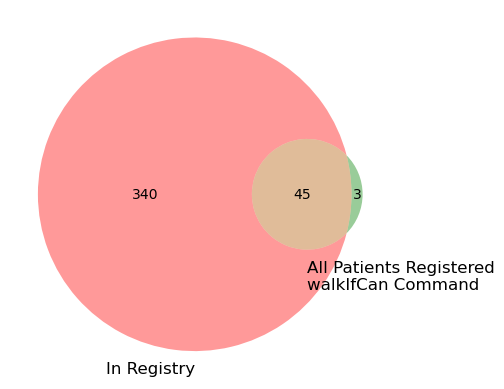

In [14]:

mask_series = (walk_if_can_df.unregistered_count == 0)
registered_commands_set = set(walk_if_can_df[mask_series].session_uuid)
tuples_list = [
    (registered_commands_set, 'All Patients Registered\nwalkIfCan Command', 'have walk commands registered for all patients in the triage scenes')
]
fig = nu.plot_right_circles(tuples_list, draw_a_two_circle_venn_diagram, verbose=False)

In [88]:

walk_if_can_df.sample(8).T

,312,412,378,174,277,420,365,1
session_uuid,b97bfac8-c52a-4019-8494-1e9ae36df7cf,fa155795-d519-45a5-89a4-0ee8c4ea756d,e77c15e0-d0de-413d-a471-20a285e81387,677d1c18-f292-4bcb-924d-52f5e762533f,a437d61b-adad-424f-9714-83382548fda2,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,dfd3aa1c-7b73-43a7-80c0-80beeabcd985,00b2e9d8-c3bb-4d89-92c1-abce5c4a0655
scene_id,1,1,0,0,0,5,1,1
patient_count,11,12,11,11,11,11,11,11
actions_list,"[SESSION_START, walk, walkIfCan x7, let's see ...","[SESSION_START, alright if you can hear me and...","[SESSION_START, everybody if you can hear me g...","[SESSION_START, SESSION_END]","[SESSION_START, all right everyone who can wal...","[SESSION_END, SESSION_START, walk, walkIfCan x...","[SESSION_START, alright if you can walk go ahe...","[SESSION_START, hi alright if you can stand pl..."
walk_if_can_count,7,8,9,0,11,7,7,7
patient_sorts_list,[walker],[waver],[walker],[walker],[walker],[walker],[walker],[walker]
moderator_count,0,0,0,0,0,0,0,0
unregistered_count,4,4,2,11,0,4,4,4


In [90]:

walk_if_can_df.patient_sorts_list.map(lambda x: str(x)).unique()

array(["['walker']", "['waver']", '[None]'], dtype=object)

In [71]:

mask_series = (walk_if_can_df.unregistered_count == 0)
print(mask_series.sum())
print([len(actions_list) for actions_list in walk_if_can_df[mask_series].actions_list])

54
[12, 13, 9, 6, 8, 7, 10, 4, 6, 12, 6, 5, 4, 11, 6, 14, 7, 11, 6, 6, 4, 6, 5, 4, 6, 4, 6, 7, 11, 4, 8, 8, 9, 6, 11, 8, 6, 7, 6, 6, 8, 5, 4, 8, 10, 5, 4, 6, 4, 6, 4, 9, 14, 7]


In [72]:

max_unregistered_count = walk_if_can_df.unregistered_count.max()
mask_series = (walk_if_can_df.unregistered_count == max_unregistered_count)
print(mask_series.sum())
for actions_list in walk_if_can_df[mask_series].actions_list: print(actions_list)

5
['SESSION_START', 'SESSION_END']
['SESSION_START', 'SESSION_END']
['SESSION_START', 'SESSION_END']
['SESSION_START', 'SESSION_END']
['SESSION_START', 'SESSION_END']


In [73]:

max_moderator_count = walk_if_can_df.moderator_count.max()
mask_series = (walk_if_can_df.moderator_count == max_moderator_count)
print(mask_series.sum())
for actions_list in walk_if_can_df[mask_series].actions_list: print(actions_list, end='\n\n')

1
['number of treated patients number of walking patients number of waving', 'walk to the safe area x1', 'walkIfCan x11', 'SESSION_START', 'justin walker', 'walkIfCan x11', 'if you can stand and walk walk over here', 'if you can stand and walk walk over here', 'go back', 'walkIfCan x2', 'sir you wanna move it all these guys go', 'hey go back to the sky over here', 'SESSION_END']



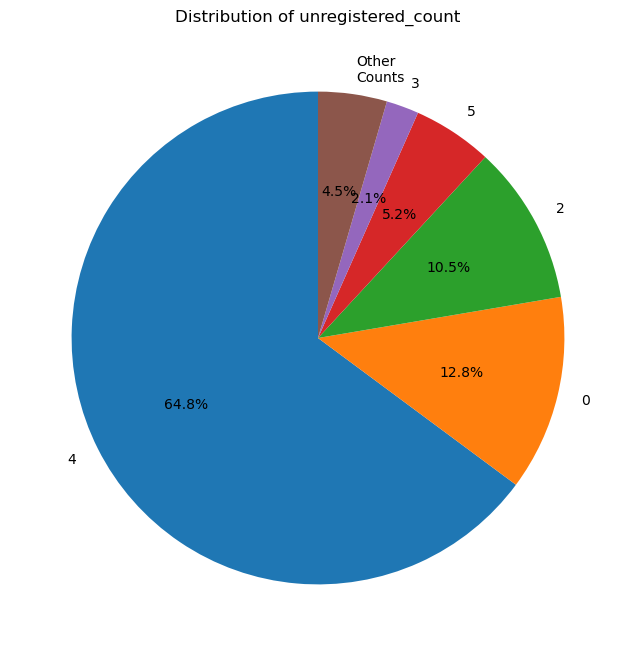

In [74]:

fig = nu.plot_grouped_pie_chart(walk_if_can_df, 'unregistered_count', 'Other\nCounts')


# Look at the sequence that happens after the moderator presses the button

In [18]:

# Figure out which of the popular command descriptions is caused by pressing the moderator button
walk_mask_series = frvrs_logs_df.voice_command_message.isin(['walk to the safe area'])
frvrs_logs_df[walk_mask_series].voice_command_command_description.value_counts().head(6)

walk                                       414
can you walk                                14
can anybody walk                            10
walk over there                              7
walk to the safe zone                        6
if you can walk please go to the stairs      4
Name: voice_command_command_description, dtype: int64

In [21]:

# Create a boolean mask to filter start/stop and the walk commands received by patients
voice_actions_list = ['SESSION_END', 'SESSION_START', 'S_A_L_T_WALK_IF_CAN']
actions_mask_series = frvrs_logs_df.action_type.isin(voice_actions_list)

# Include VOICE CAPTURE actions with questionable walk commands
questionable_mask_series = ((frvrs_logs_df.action_type == 'VOICE_CAPTURE') & frvrs_logs_df.voice_capture_message.isin(questionable_walk_commands))
actions_mask_series |= questionable_mask_series

# Include voice commands with the message "walk to the safe area"
walk_mask_series = (frvrs_logs_df.action_type == 'VOICE_COMMAND') & frvrs_logs_df.voice_command_message.isin(['walk to the safe area'])
actions_mask_series |= walk_mask_series

# Group each scene that potentially has questionable walk commands
scene_gb = frvrs_logs_df[actions_mask_series].sort_values(['action_tick']).groupby(fu.scene_groupby_columns)

# Loop through each unique file/scene combination and create a sequence dictionary
sequence_dict = {}
for (session_uuid, scene_id), scene_df in scene_gb:
    
    # Filter for only scenes with questionable walk commands
    # mask_series = ((scene_df.action_type == 'VOICE_CAPTURE') & scene_df.voice_capture_message.isin(questionable_walk_commands))
    
    # Filter only for scenes where the moderator button was pushed
    mask_series = (scene_df.voice_command_command_description == 'walk to the safe zone')
    if mask_series.any():
        
        key = (session_uuid, scene_id)
        actions_list = []
        action_types_set = set()
        for row_index, row_series in scene_df.iterrows():
            action_type = row_series.action_type
            voice_command_command_description = row_series.voice_command_command_description
            voice_capture_message = row_series.voice_capture_message
            if action_type == 'S_A_L_T_WALK_IF_CAN':
                patient_id = row_series.s_a_l_t_walk_if_can_sort_command_text
                actions_list.append(patient_id)
                action_types_set.add(patient_id)
            elif action_type == 'VOICE_COMMAND':
                actions_list.append(voice_command_command_description)
                action_types_set.add(voice_command_command_description)
            elif (action_type == 'VOICE_CAPTURE'):
                actions_list.append(voice_capture_message)
                action_types_set.add(voice_capture_message)
            else:
                actions_list.append(action_type)
                action_types_set.add(action_type)
        sequence_dict[key] = actions_list

In [25]:

actions_list = list(nu.get_random_subdictionary(sequence_dict, 1).values())[0]
for element in ['walkIfCan', 'walk to the safe area']:
    actions_list = nu.replace_consecutive_elements(actions_list, element)
actions_list

['SESSION_START', 'walk to the safe zone', 'walkIfCan x16', "oh that's a good point i have not gotten to the walkers yet can i change somebody's", 'walkIfCan x11', "call already and i'll move over", 'walkIfCan x3', "you're able to walk OK can you tell me your name", 'SESSION_END']

In [28]:

for (session_uuid, scene_id), actions_list in sequence_dict.items():
    
    # Get the entire scene history
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
    scene_df = frvrs_logs_df[mask_series]
    
    # Get the patient count
    patient_count = fu.get_patient_count(scene_df)
    
    # Replace consecutive elements with an "x" notation
    for element in ['walkIfCan', 'walk to the safe area']:
        actions_list = nu.replace_consecutive_elements(actions_list, element)
    print(patient_count, actions_list)

4 ['SESSION_START', "your your global source if you can hear my voice I want you to walk over here where it's safe", 'walkIfCan x3', 'walk to the safe zone', 'walkIfCan x4', 'SESSION_END']
11 ['SESSION_START', 'walk to the safe zone', 'walkIfCan x16', "oh that's a good point i have not gotten to the walkers yet can i change somebody's", 'walkIfCan x11', "call already and i'll move over", 'walkIfCan x3', "you're able to walk OK can you tell me your name", 'SESSION_END']
11 ['SESSION_START', 'I want you to walk over here to the safe zone', 'walkIfCan x7', 'walk to the safe zone', 'walkIfCan x2', 'can you walk', 'walkIfCan x7', 'OK so you can still walk', 'SESSION_END']
11 ['SESSION_START', 'walk to the safe zone', 'walkIfCan x7', 'SESSION_END']
11 ['SESSION_START', 'alright if you can walk come over here', 'walkIfCan x11', 'walk to the safe zone', 'walkIfCan x43266', 'SESSION_END']
11 ['SESSION_START', 'walk to the safe zone', 'walkIfCan x11', "who's not walking to the safe zone if you c


# Voice Capture

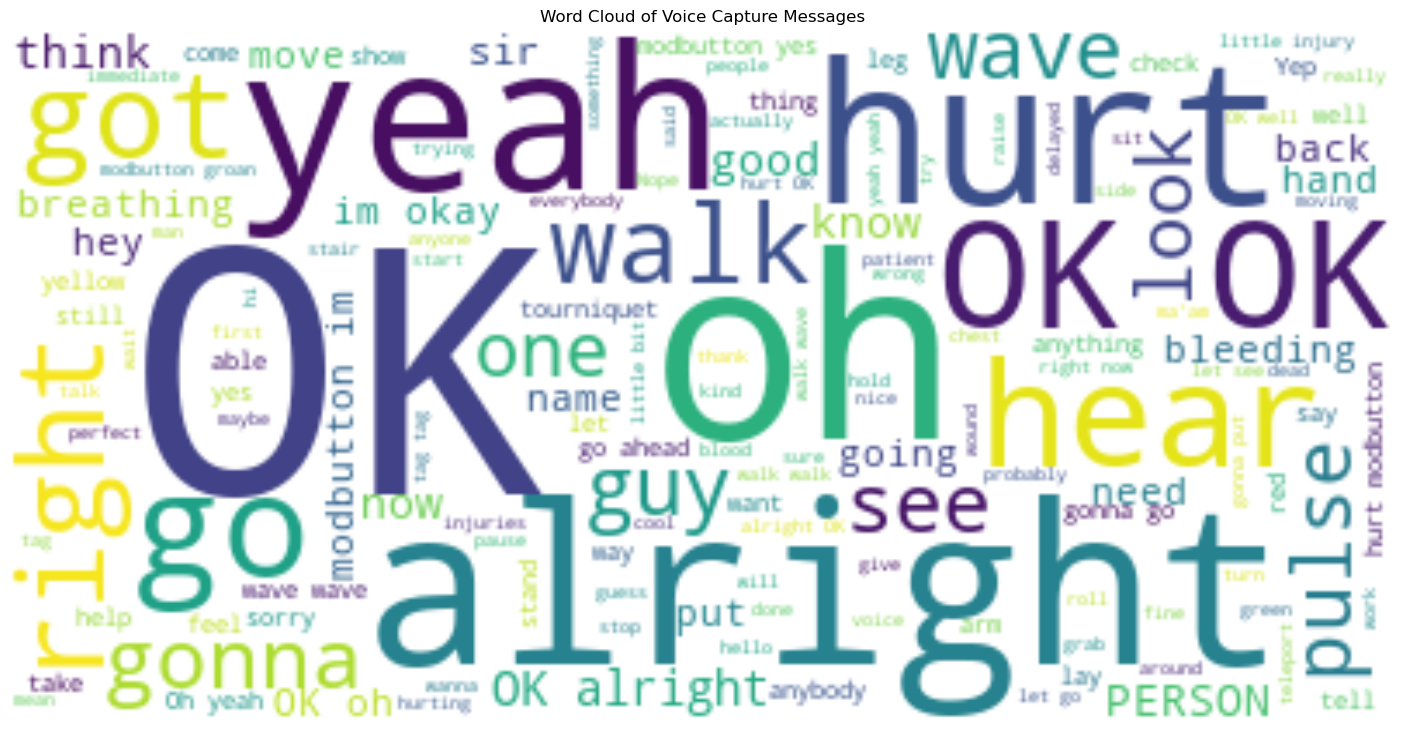

In [5]:

# Flatten the list of lists of words
mask_series = (frvrs_logs_df.action_type == 'VOICE_CAPTURE')
vcm_series = frvrs_logs_df[mask_series].voice_capture_message
vcm_series_list = vcm_series.tolist()
wordcloud_words = []
for voice_capture_words in vcm_series_list:
    wordcloud_words += voice_capture_words.split()

# Create a word cloud object
wordcloud = WordCloud(max_font_size=100, max_words=200, background_color='white').generate(' '.join(wordcloud_words))

# Plot the word cloud
plt.figure(figsize=(18, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Voice Capture Messages')
plt.show()

In [6]:

vcm_series.value_counts()

OK                                                   3143
are you hurt                                         1503
wave                                                  704
alright                                               683
modbutton no                                          557
                                                     ... 
he walked for me but still                              1
well i'll just say                                      1
alright go upstairs and see the ambulance drivers       1
my knees                                                1
Speech recognition working                              1
Name: voice_capture_message, Length: 19348, dtype: int64

In [7]:

def ultimate_tokenize(sentence):
    
    # Remove punctuation and digits
    sentence = sentence.translate(str.maketrans('', '', string.punctuation + string.digits))
    
    return word_tokenize(sentence.lower())

In [8]:

def show_corpus_stats(sents_list):
    sent_count = len(sents_list)
    
    # Calculate the average word length
    word_ave = np.mean([len(word) for sent in sents_list for word in sent])
    
    print(f'The voice capture corpus contains {sent_count:,} sentences with an average of {word_ave:0.2} words each.')

In [9]:

import nltk

nltk.download('punkt', download_dir='/home/dbabbitt/nltk_data')

[nltk_data] Downloading package punkt to /home/dbabbitt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

# Questionable command (“go over there”) issued
go_list = []
go_regex = re.compile(r'\bgo\b', re.IGNORECASE)
for voice_capture_words in vcm_series_list:
    if go_regex.search(voice_capture_words): go_list.append(voice_capture_words)
print(f'questionable_commands_list = {Series(go_list).value_counts().index.tolist()}')

In [11]:

# Create a list of questionable voice captures
questionable_commands_list = [
    'go', 'go back', 'go over there', "we're gonna go", "so we're gonna go with", "let's go over here", 'go there', 'can you go walk over there',
    'go here', 'go over here', 'Go', 'go this way', 'go to the', 'if you can walk please go to the stairs', 'go ahead and turn around',
    'so you know i would walk in see those four patients i would go and say if anybody can hear me i want you to WLK over here OK',
    'if you can walk go to a safe space over there', 'go that way', 'if you guys can walk go behind me',
    "we're gonna go over here we're gonna come over here", 'thank you just go ahead and sit along the steps',
    'can i go ahead and OK can i get anybody to walk move over here', 'oh can you go over there',
    'If you can hear my voice go to the safe area if you can hear my voice go to the safe area wave your arm if you can hear me',
    'go ahead and walk the safe zone if you can hear my voice go ahead and raise your hand', 'are you going to hear my voice go ahead and walk towards me',
    'go back to heaven', 'OK so if you can walk go to the safety zone',
    "so first thing you do is to do i like talk it through like you know the scene safe kind of things alright if you can hear me and you're safe" +
    " i want you to go to a safe area no one's getting up yep get up there we go",
    "him sit down on the step so that way he's not moving around sir can you go sit down on the", "yeah i'm not worried about you go over there",
    'wave oh you got a little wave there you go there you go alright', 'you go home', 'OK if you can hear me stand up and go to the safe zone',
    'go go to the safe zone things stand up', "can walk walk over here so they're gonna go to their spot",
    "so the first thing we're gonna do when we get in here is we wanna sort these patients so go ahead and use your sort commands to get these" +
    " folks moving OK anybody that can walk walk to the stairs", 'alright so go and begin with these guys on my practice alright anybody can stand up and' +
    ' walk please stand up and walk and walk to the staircase on the right', "OK go ahead and walk over to the safe zone wherever that's at",
    'they only go over there OK can anybody hear if you can hear me can you wave', 'alright go stand over by the exit if you can hear me wave your hand' +
    ' wave your hand', 'I need you to go outside', 'if anybody can hear me go outside if you can stand up and walk I need you to go up either flight of' +
    ' stairs and wait outside', 'go over there to the steps', 'go ahead and wave for me if you can', 'go ahead wait for me',
    'can everybody go over here that can walk', "don't stay there until you walk away and then it'll go back OK", 'there you go go to the sky',
    'go walk and stand next to them OK', 'sweep sweep sweep sweep sweep no what are you you you need to go',
    "everyone who can hear my voice and can walk I want you to go over to those stairs and we'll be over to check on you", 'you can go outside',
    'OK then I need you to go outside', "there's a safe area over there please go over there", 'hey go back to the sky over here', 'i know there go',
    'go ahead and wave to me if you need help', 'go if you', 'sir you wanna move it all these guys go', 'go home', 'you gotta go through',
    "OK hi if you can hear me can you please go over to the stairs you're able to walk can you please move to the stairs", "that's the only place you could go so",
    'all right everyone who can walk please go over to the stairs', "don't give you a delayed tag you go over here", "you guys hurt go upstairs if you're hurt",
    'go to the exit', 'hey can you move go upstairs', 'we can move can you leave and go up the stairs', "that should heal overtime but i'd like you to go to the",
    "all right everybody if you're able to walk go over there", 'OK go away', 'OK go right there', 'so go here', 'go over there can anybody raise their hand',
    'hey go away', 'if you can walk go that way or that way can anybody wave', 'just go red here OK', 'OK so go to this one first', 'nothing ' +
    'go away', 'alright go ahead and have a seat by the stairs for me', 'if you can wave your arm go ahead and wave', 'go away',
    "she's gonna go and start the tutorial for you so first thing you want to do in the tutorial is sort your patience OK and so you're" +
    " gonna use those two those two sort of commands so go ahead and start just let me know anybody who can walk get up and walk towards the stairs",
    "can I have you just go over to our collection point and somebody will be there actually you can just go on to the ER or go home or do" +
    " whatever you need to do right now but I'm gonna have you leave this area please OK for your safety",
    "OK walk that way and go to the collection point somebody will be there to help you OK what's that",
    "you too you look like you're doing pretty good I'm gonna have you go over to our collection point will there be more people there to help you OK",
    "OK buddy I want you to go ahead and go over to the collection point that we have there'll be more people over there to help",
    'I want you to stand up and go to the collection', "so this is your scenario you've been dispatched to report of an explosion at a subway" +
    " station you're the first on scene you're the only resource there and help us 15 minutes away oh gosh OK alright if anyone can hear sound" +
    " my voice stand up and go to the right or the stairs", 'just go here', "oh crap oh I'm already over here alright sorry if anybody can wave" +
    " their hand go ahead and wave at me real quick", 'OK so everyone can hear me sound my voice stand up and go to the right', "let's go who can wave",
    "what's up anybody that can walk go to the safe zone", 'OK can you go ahead and walk', 'anybody that can walk please could go ahead and walk away',
    'anybody that can walk go ahead and walk out OK', "man that's just I'm gonna make her immediate sorry bro I know you you probably said I" +
    " could do something else to her Sir why don't you go sit over there on the stairs", "good post so why don't you go sit down OK",
    'good anybody that can walk go to the safe area', 'if you can walk please get up and go to the stairs for me',
    'start with your global sort so if you can hear my voice I want you to walk to the safe area go ahead and say', 'so go ahead and walk',
    'there we go OK hi Sir can you wave your hands for me', 'go and wave again', 'if you can wave go ahead and wave',
    'if you can hear my voice go to the safe area', 'thank you thank you to my right there you go over by the stairwell please', 'Go to start',
    'alright so go over here', 'alright anybody that can walk get up and go over there', 'so go ahead and start with your commands ' +
    'if you can walk move to the stairs please', 'go walk away oh **** that one real', 'you go there', 'You go over there and walk OK alright',
    "OK anybody that can walk please walk towards me come back here by the stairs up against the wall good anyway I can hear and can wave " +
    "please wave wave at me good OK alright I'm gonna go and start", 'go to the safe zone over there',
    "if you can hear me and you're able to walk i need you to go up the stairs and evacuate",
    'alright you can hear my voice go ahead and walk over to the stairs over here',
    'alright hi everyone whoever can walk could you go to the safe zone please', 'alright if you go to the safe zone please do so', 'go to start',
    'and then go ahead and wait for me if you can wave', 'no go ahead and walk over there', 'go to', 'two nice if you can wave go ahead and wave your hand',
    'alright if you can walk go ahead and walk over to these stairs', 'if anyone can walk go ahead and walk over to the stairs',
    'anybody can walk go to the stairs', 'so should i go ahead and start if you can hear me go walk to the safe zone',
    'OK if you can hear me and you can walk go to the safe zone', 'right OK if you can hear me go ahead and walk to the stairway',
    "anybody that can hear me wave OK we're gonna go", "WA oh you i'm ready to go OK sorry yeah so i can just talk to " +
    "them alright if you can hear me go ahead and stand up and walk over to my right", 'OK so nobody can walk if you can hear me go ahead',
    'if you can stand and walk please go over to a bench', "alright everyone i'm here to help anyone who can stand up and walk please " +
    "go to the wall", 'go over to a wall', 'anyone who can stand and get up please go over to a bench',
    "hey there we go now they're moving anyone who can hear me but can't get up and walk please raise your hand", 'OK and if you can hear me go ' +
    'ahead and raise your hand and wave it put it in the air OK perfect thank you', 'go ahead and raise your hand and wave at me', 
    'alright if you can walk please go over there', 'alright if you can walk can you go to the safe zone please',
    'alright go ahead and rate wave to me if you can hear my voice', 'alright all that you waved can you walk ' +
    'towards me and go to the place where they told you to walk to', "i can go ahead and start alright if you can hear my voice and you're" +
    " able to stand up and walk please stand up and walk and sit over in this direction please so the green area everyone stand up anyone" +
    " who can walk walk over here", 'go ahead and walk that way OK go ahead and walk over there', 'OK go ahead and walk over there OK',
    'where am i at if you can walk go stand over there', 'go ahead and walk over there are you hurt anywhere',
    'anybody that can walk go over there', 'hey can you go over there and sit on that bench can you walk',
    'alright do i need to go is do i need to go like back way over there',
    "everybody if you can hear me go to the stairs over here behind me to my right if you can walk please do doesn't matter which " +
    "patient i go to 1st", "well he looks anybody that can get up and walk i'll have you go off to this bench over here",
    'OK can you go to the safe area for me', 'OK if you can hear me go to the safe area oh good job', 'go to go to the safe area OK',
    'if you can hear my voice go ahead and put your hands up and raise', 'red waved me go and waved me if you can hear my voice',
    'alright everybody who can hear me go go ahead and walk over to the bottom of the stairs if you can', 
    'everybody can hear me and can walk go ahead and walk over here to the bottom of the stairs', 
    "everybody else who can hear me but can't walk go ahead and wave at me", 'go over there can you walk over there',
    "OK well here take my hand we're gonna go walk on over here", 'moonlight now I I want you to go over to that corner',
    'are you go ahead and walk over there can you go walk over alright alright', 'if you can hear my voice get up and go to the safe zone',
    'if you can walk go to the green triage area', 'if you can hear me and you can walk stand up and go over there',
    "I don't know how to point you you go over there but those people at the bottom of the stairs", 
    'hearing anything if you can hear my voice please go over to the stairwell', 'if you can hear my voice please go to the stairwell',
    'if you can walk go to the green section', 'alright anyone can stand up go to stairs', 'go to the sky first', 'You go here',
    'go to the stairs', 'just stand up and go away now OK', 'you guys go up the stairs',
    "ma'am if you're able to stand on each you to go to the staircase behind me", 'real quick alright hey if you can if you can walk move over to my right side ' +
    'back here by these steps go now move', 'if you can hear my voice and walk get up and go to the stairs',
    'alright go upstairs and see the ambulance drivers', 'oh my gosh OK alright if you guys can hear me go ahead and make your way up the stairs',
    "i'm gonna go ahead and have you head up the stairs OK", "OK OK i'm gonna go ahead and have your head up the stairs OK"
]

In [13]:

# Questionable tokenized command ([“go”, “over”, “there”]) issued
questionable_tokenized_commands_list = [ultimate_tokenize(x) for x in questionable_commands_list]
show_corpus_stats(questionable_tokenized_commands_list)

The voice capture corpus contains 190 sentences with an average of 3.5 words each.


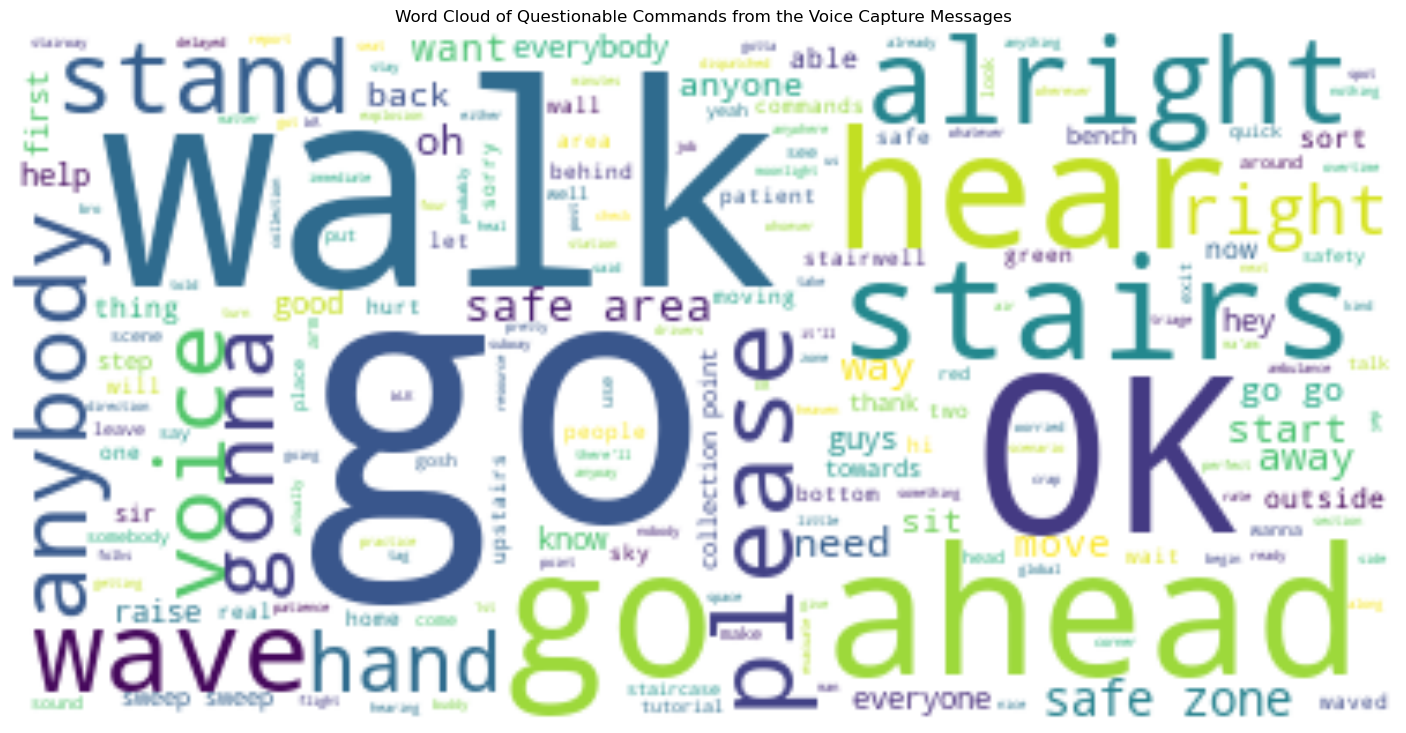

In [14]:

wordcloud_words = []
for voice_capture_words in questionable_commands_list:
    wordcloud_words += voice_capture_words.split()

# Create a word cloud object
wordcloud = WordCloud(max_font_size=100, max_words=200, background_color='white').generate(' '.join(wordcloud_words))

# Plot the word cloud
plt.figure(figsize=(18, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Questionable Commands from the Voice Capture Messages')
plt.show()

In [15]:

# Filter for questionable voice commands
questionable_mask_series = (frvrs_logs_df.action_type == 'VOICE_CAPTURE') & frvrs_logs_df.voice_capture_message.isin(questionable_commands_list)
frvrs_logs_df[questionable_mask_series].voice_capture_command_description.unique().tolist()

[nan, 'NA']

In [16]:

# Filter for voice commands with the message "walk to the safe area"
walk_mask_series = (frvrs_logs_df.action_type == 'VOICE_COMMAND') & frvrs_logs_df.voice_command_message.isin(['walk to the safe area'])
unquestionable_commands_list = frvrs_logs_df[walk_mask_series].voice_command_command_description.unique().tolist()
print(f'questionable_walk_commands = {sorted(set(questionable_commands_list) - set(unquestionable_commands_list))}')

questionable_walk_commands = ['Go', 'Go to start', 'I need you to go outside', "OK OK i'm gonna go ahead and have your head up the stairs OK", 'OK and if you can hear me go ahead and raise your hand and wave it put it in the air OK perfect thank you', "OK buddy I want you to go ahead and go over to the collection point that we have there'll be more people over there to help", 'OK go away', 'OK go right there', 'OK so go to this one first', 'OK then I need you to go outside', 'You go here', 'alright anyone can stand up go to stairs', 'alright do i need to go is do i need to go like back way over there', 'alright go ahead and have a seat by the stairs for me', 'alright go ahead and rate wave to me if you can hear my voice', 'alright go stand over by the exit if you can hear me wave your hand wave your hand', 'alright go upstairs and see the ambulance drivers', 'alright so go over here', 'and then go ahead and wait for me if you can wave', "anybody that can hear me wave OK we're gonna go"

In [19]:

mask_series = (frvrs_logs_df.action_type == 'S_A_L_T_WALK_IF_CAN')
frvrs_logs_df[mask_series].s_a_l_t_walk_if_can_sort_command_text.unique().tolist()

['walkIfCan']

In [23]:

session_uuid, scene_id = [k for k, v in sequence_dict.items() if v[1] == 'alright if you can walk come over here'][0]

# Get entire scene history
mask_series = True
for cn in fu.scene_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
scene_df = frvrs_logs_df[mask_series]

In [24]:

fu.get_patient_count(scene_df)

11


# Maintenance

In [18]:

# Filter for voice commands with the message "wave if you can"
wave_mask_series = (frvrs_logs_df.action_type == 'VOICE_COMMAND') & frvrs_logs_df.voice_command_message.isin(['wave if you can'])
unquestionable_commands_list = frvrs_logs_df[wave_mask_series].voice_command_command_description.unique().tolist()
c_list = [c for c in questionable_commands_list if 'wave' in c]
print(f'questionable_wave_commands = {sorted(set(c_list) - set(unquestionable_commands_list))}')

questionable_wave_commands = []


In [ ]:

[fn for fn in dir(patients_set) if not fn.startswith('_')]

In [ ]:

patients_set.symmetric_difference(walk_if_cans_set)

In [ ]:

len(patients_set)

In [ ]:

len(walk_if_cans_set)